[![Roboflow Notebooks](https://ik.imagekit.io/roboflow/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# How to Auto Train YOLOv8 Model with Autodistill

Autodistill uses big, slower foundation models to train small, faster supervised models. Using `autodistill`, you can go from unlabeled images to inference on a custom model running at the edge with no human intervention in between.

![Autodistill Steps](https://media.roboflow.com/open-source/autodistill/steps.jpg)

As foundation models get better and better they will increasingly be able to augment or replace humans in the labeling process. We need tools for steering, utilizing, and comparing these models. Additionally, these foundation models are big, expensive, and often gated behind private APIs. For many production use-cases, we need models that can run cheaply and in realtime at the edge.

![Autodistill Connections](https://media.roboflow.com/open-source/autodistill/connections.jpg)

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Image dataset preperation
- Autolabel dataset
- Train target model
- Evaluate target model
- Run video inference
- Upload dataset and model to Roboflow (comming soon)

## 🔥 Let's begin!


## ⚡ Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi



Sat Sep 23 12:37:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 466.47       Driver Version: 466.47       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   48C    P8     3W /  N/A |    727MiB /  4096MiB |     22%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 🧪 Install autodistill

**NOTE:** Autodistill is an ecosystem for using big, slower foundation models to train small, faster supervised models. Each Base, as well as the Target model, has its own separate repository and pip package.

In [2]:
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
supervision==0.9.0

'pip' is not recognized as an internal or external command,
operable program or batch file.


**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [2]:
import os
HOME = os.getcwd()
print(HOME)

d:\vs code\programes\data science\grey labs\final model


## 🖼️ Image dataset preperation

**NOTE:** To use Autodistill all you need to have is a set of images that you want to automatically annotate, and use for target model training.

In [14]:
os.mkdir(path="\images")

FileExistsError: [WinError 183] Cannot create a file when that file already exists: '\\images'

**NOTE:** If you want to build YOLOv8 on your data make sure to upload it into `images` directory that we just created. ☝️

### Display image sample

**NOTE:** Before we start building a model with autodistill, let's make sure we have everything we need.

In [15]:
import supervision as sv
IMAGE_DIR_PATH = f"{HOME}/images"
image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 24


**NOTE:** We can also plot sample of our image dataset.

In [16]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

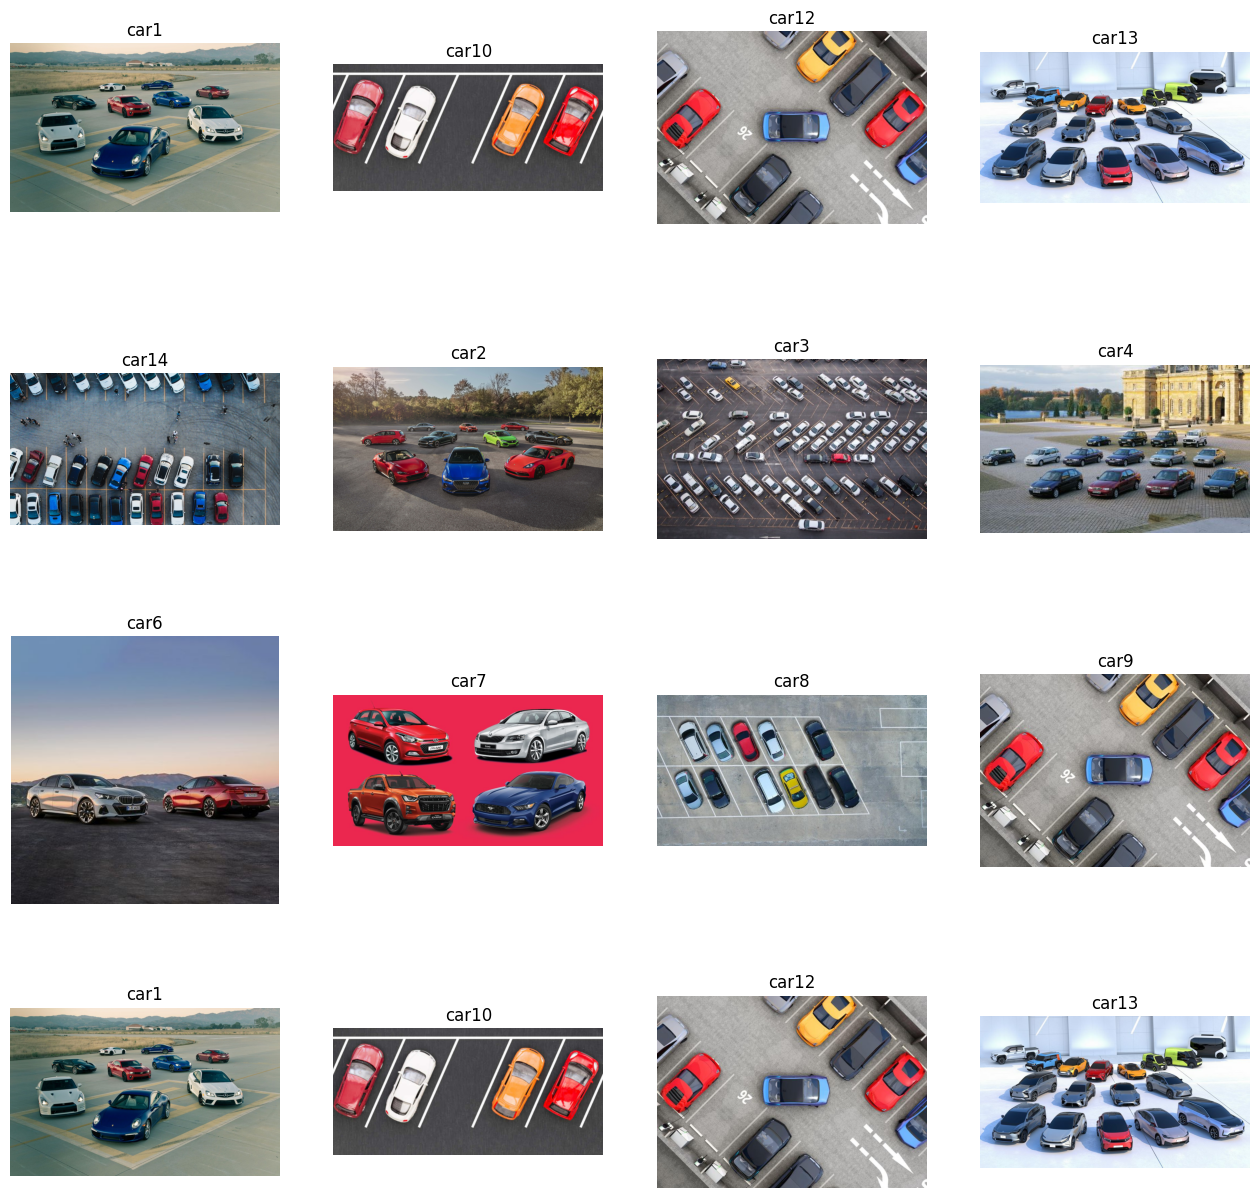

In [17]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## 🏷️ Autolabel dataset

### Define ontology

**Ontology** - an Ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [18]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "car": "car",
    "background":"background"
})

### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often multimodal and can perform many tasks. They're large, slow, and expensive. Examples of Base Models are GroundedSAM and GPT-4's upcoming multimodal variant. We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

In [19]:
DATASET_DIR_PATH = f"{HOME}/dataset"

**NOTE:** Base Models are slow... Make yourself a coffee, autolabeing may take a while. ☕

In [22]:
from autodistill_grounded_sam import GroundedSAM
base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH)

RuntimeError: Failed to import transformers.models.bert.modeling_bert because of the following error (look up to see its traceback):
Descriptors cannot not be created directly.
If this call came from a _pb2.py file, your generated code is out of date and must be regenerated with protoc >= 3.19.0.
If you cannot immediately regenerate your protos, some other possible workarounds are:
 1. Downgrade the protobuf package to 3.20.x or lower.
 2. Set PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION=python (but this will use pure-Python parsing and will be much slower).

More information: https://developers.google.com/protocol-buffers/docs/news/2022-05-06#python-updates

### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [23]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [24]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

FileNotFoundError: [Errno 2] No such file or directory: 'd:\\vs code\\programes\\data science\\grey labs\\final model/dataset/data.yaml'

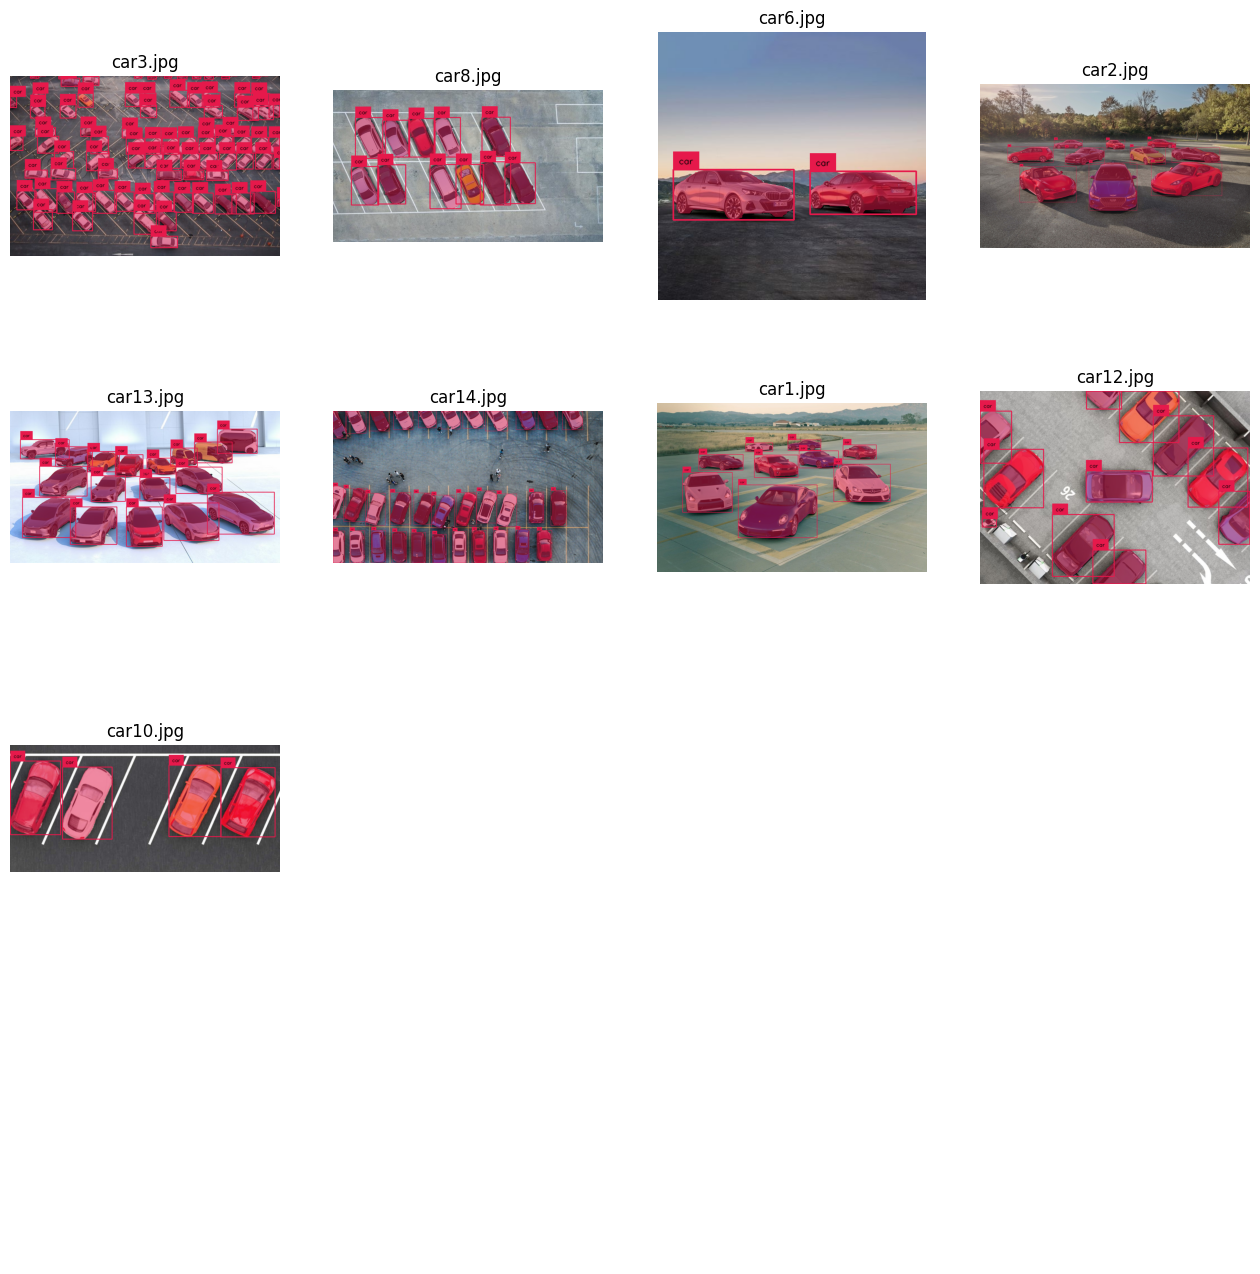

In [ ]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

## 🔥 Train target model - YOLOv8

**Target Model** - a Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLOv8 and DETR.

In [ ]:
%cd {HOME}

from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8l.pt")
target_model.train(DATA_YAML_PATH, epochs=5)

/content


100%|██████████| 83.7M/83.7M [00:01<00:00, 73.6MB/s]
New https://pypi.org/project/ultralytics/8.0.184 available 😃 Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/dataset/data.yaml, epochs=5, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, aug

## ⚖️ Evaluate target model

**NOTE:** As with the regular YOLOv8 training, we can now take a look at artifacts stored in `runs` directory.

/content


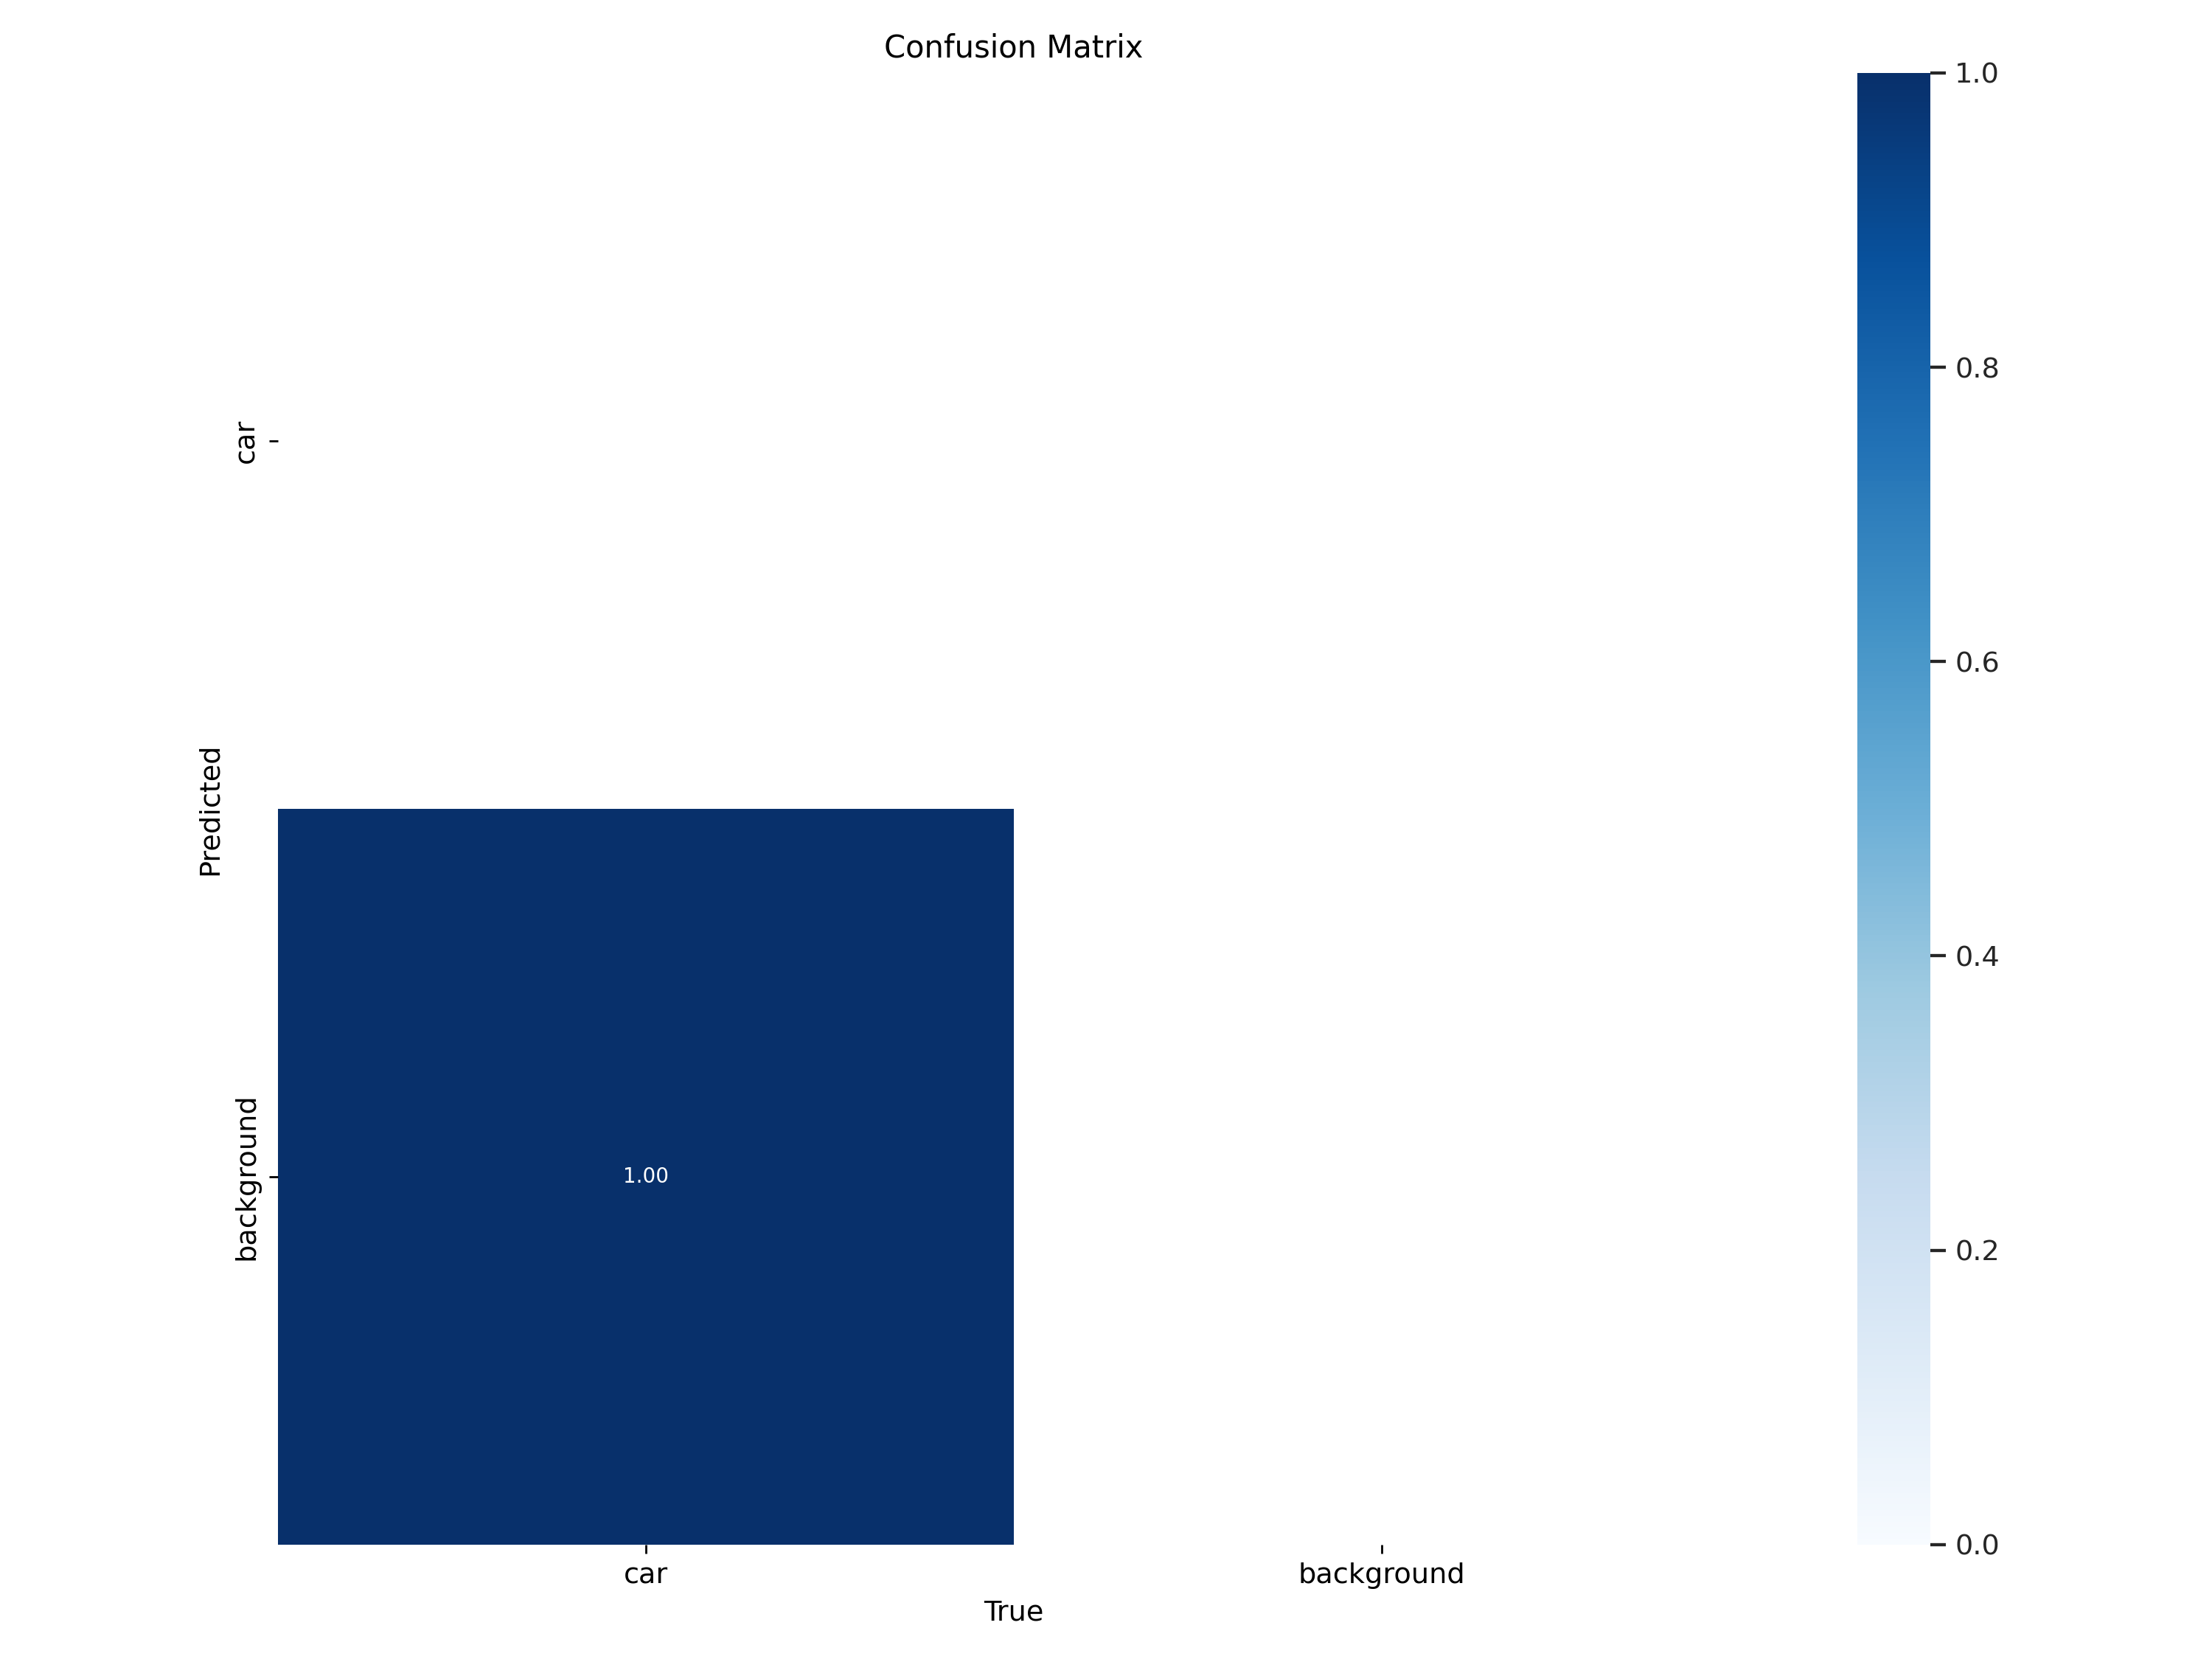

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

/content


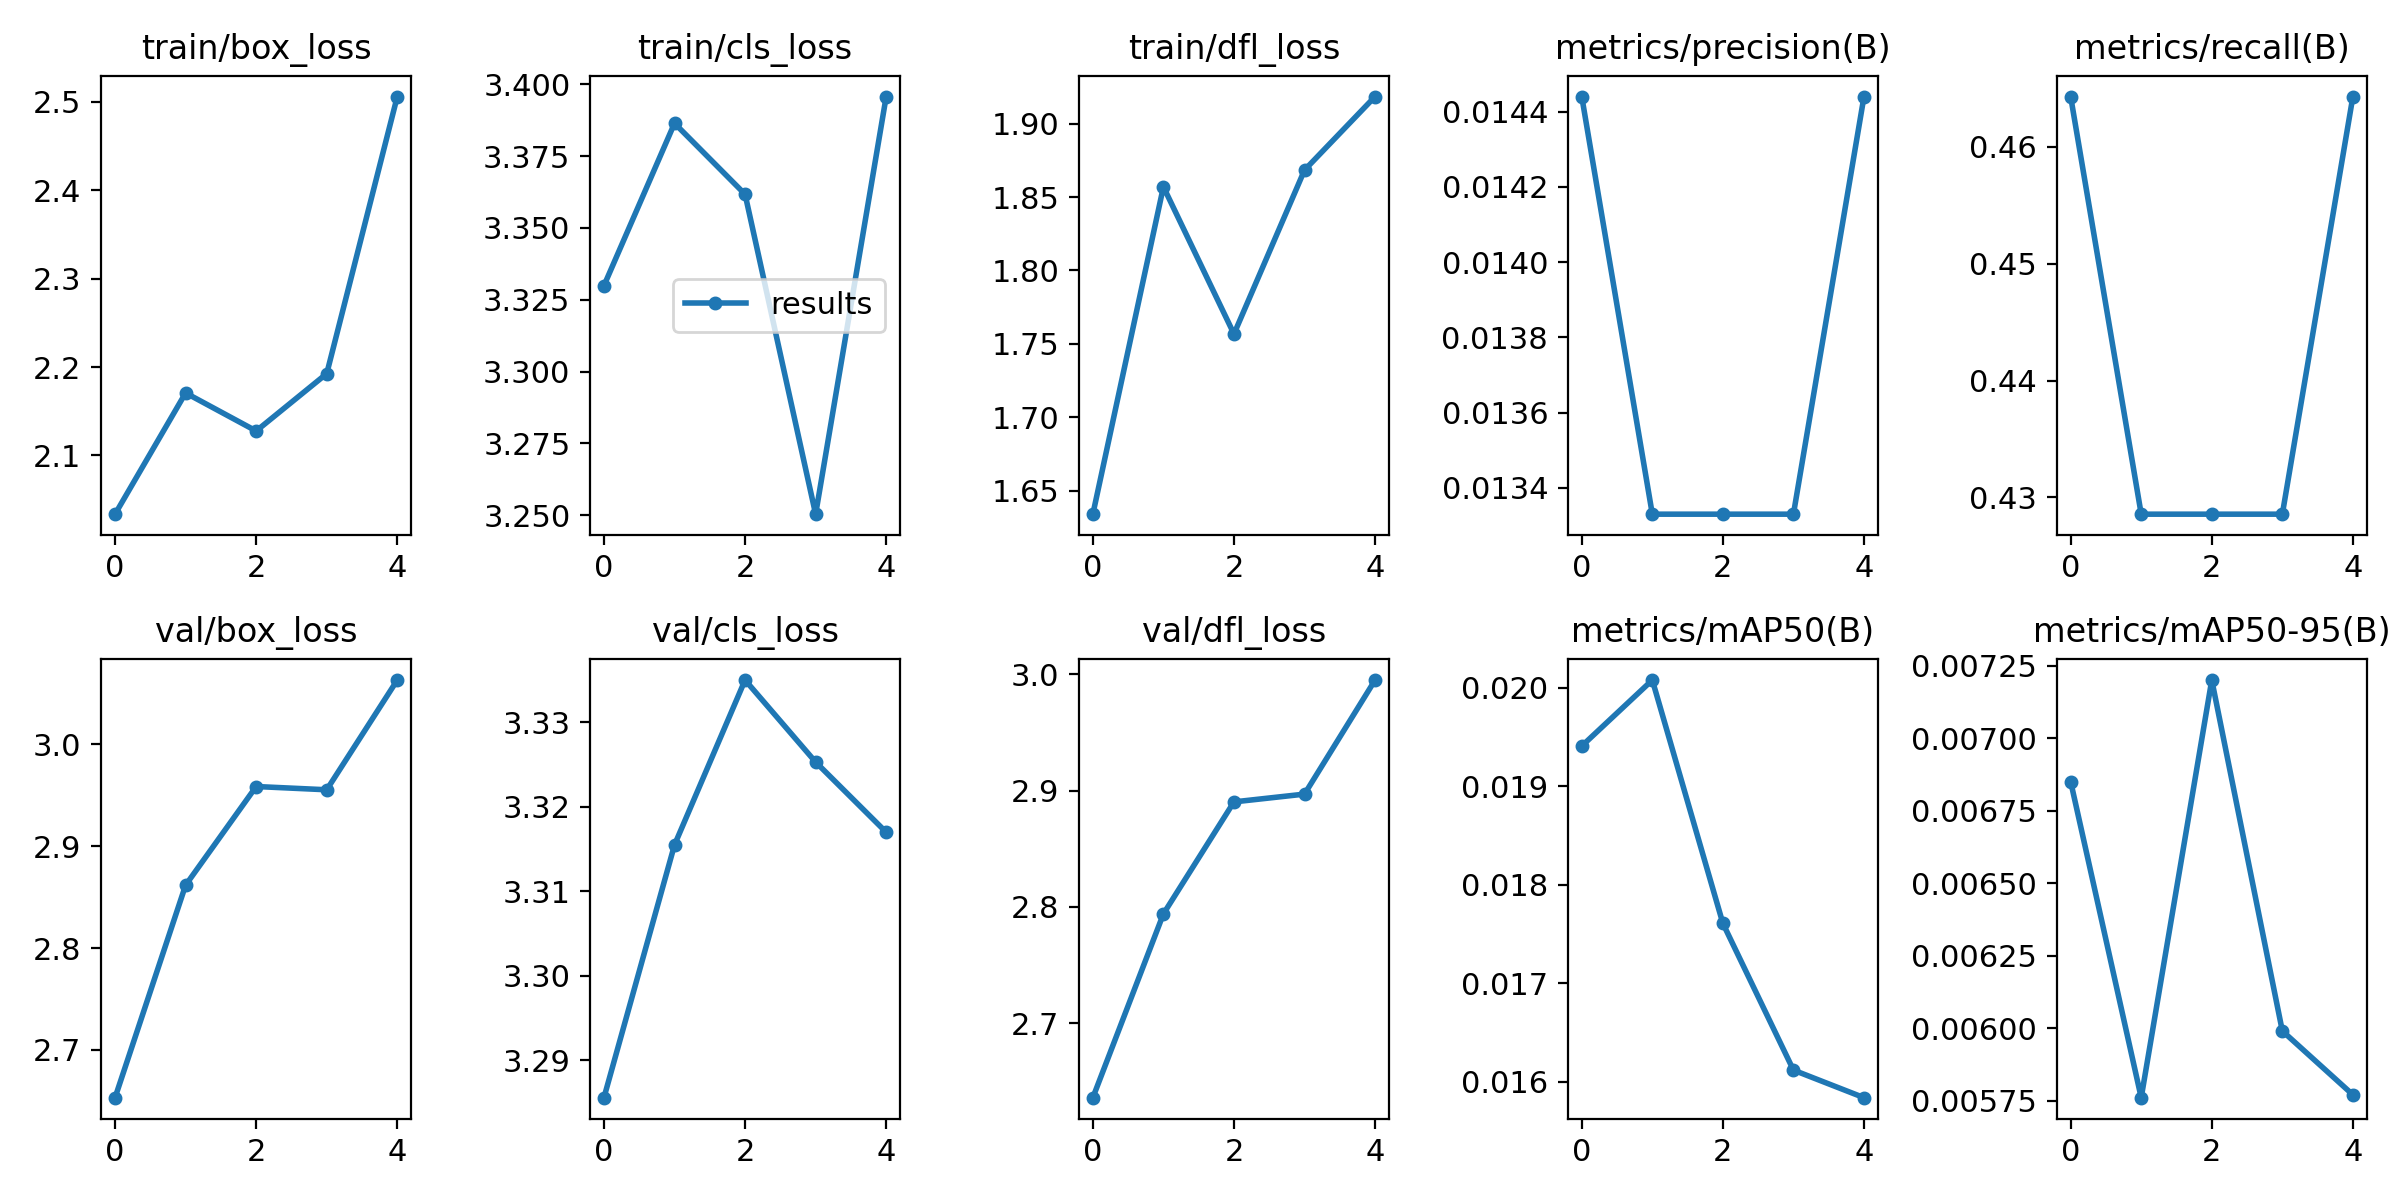

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

/content


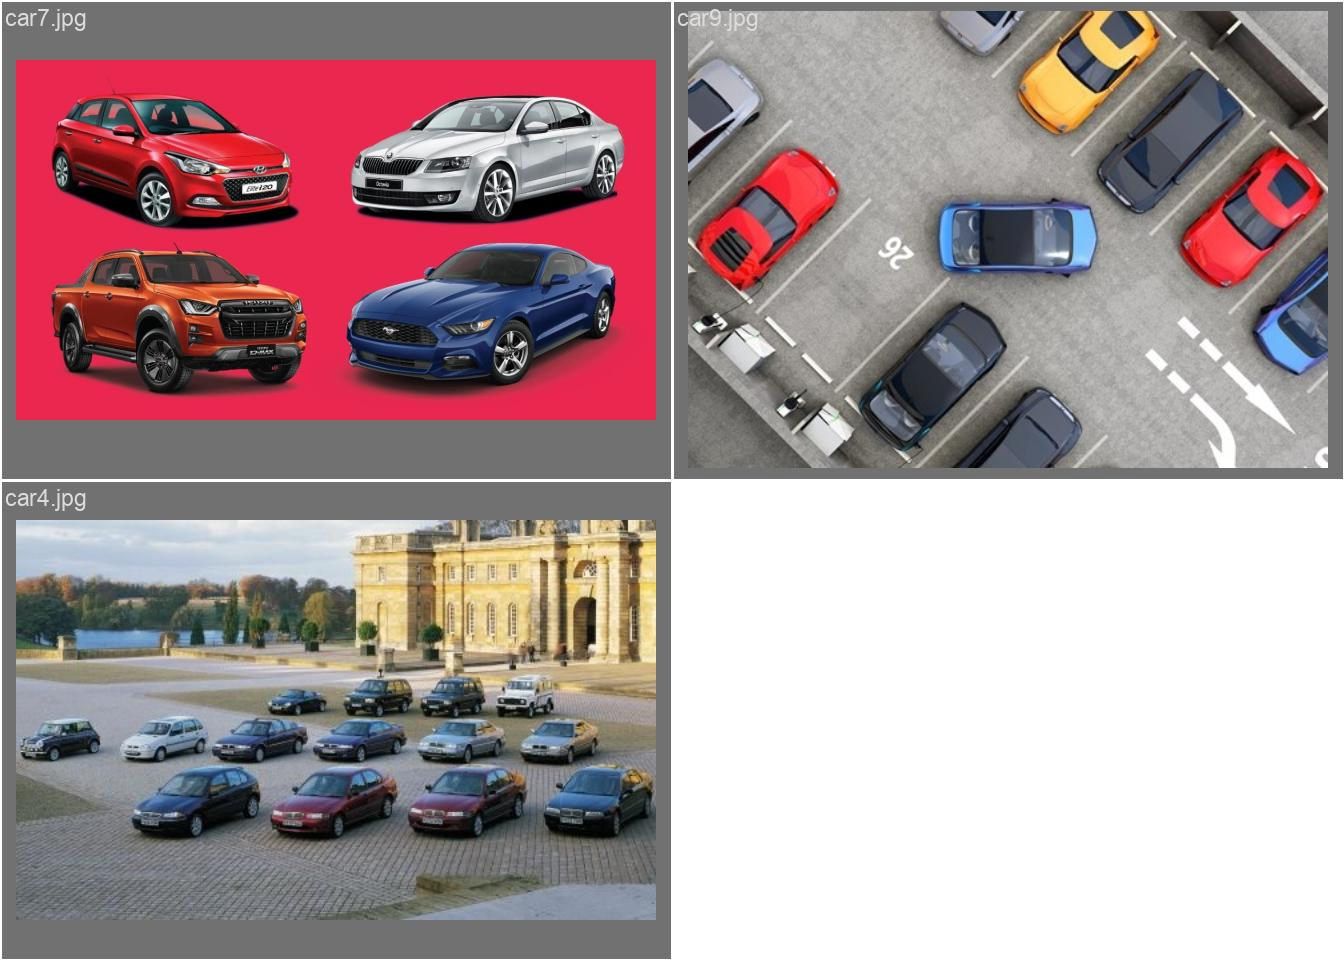

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

## Export Model to Custom Python Script and Project

In [ ]:
yolo export model=yolov8n.pt